# Goal

Analyse the sctruture of adjacency matrices and their metrics over 2008 crisis (2007 - 2008) which corresponds to the first year of congress 111. In order to compare the difference, it will be added to the analysis 2006 (last year of congress 109) until first year of congress 111.


## Main Takeaways 
- In the begining of the crisis, the two parties seemed to agreed more about their bills' position than in the end
- The subject "energy ~ oil" had a remarkable volume during the begin of the crisis


In [8]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

import pickle
import networkx as nx

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
ALL_LAWS_PATH = '../data/all-votes/laws_20years.csv'
ALL_ADJACENCY_PATH = '../data/all-votes/all_adjacency.pickle'
ALL_SUBJECT_PATH = '../data/all-votes/bills_20years.csv'
ALL_ADJACENCY_METRIS_PATH = '../data/all-votes/all_adjacency_metric.csv'
pal = {'republican': '#ff0000', 'democrats': '#0000ff'}
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=2, color_codes=True, rc=None)

In [3]:
all_laws = pd.read_csv(ALL_LAWS_PATH)
all_bills = pd.read_csv(ALL_SUBJECT_PATH)
all_adjacency_metrics = pd.read_csv(ALL_ADJACENCY_METRIS_PATH)
all_laws['law_id'] = all_laws['vote_uri'].apply(lambda x: '_'.join(x.split('/')[4:]).split('.')[0])
all_laws = all_laws.merge(all_bills, on='law_id', how='left')
all_laws = all_adjacency_metrics.merge(all_bills, on='law_id', how='left')
all_laws['month'] = all_laws['date'].apply(lambda x: '-'.join(x.split('-')[0:2]))

with open(ALL_ADJACENCY_PATH, 'rb') as handle:
    adjacencies = pickle.load(handle)
print(len(adjacencies))

LOOKUP_RESULT = {
    'Agreed to': 'passed', 'Rejected': 'rejected', 'Nomination Confirmed': 'passed',
    'Cloture Motion Agreed to': 'passed', 'Amendment Rejected': 'rejected', 'Confirmed': 'passed',
    'Passed': 'passed', 'Amendment Agreed to': 'passed', 'Motion Rejected': 'rejected',
    'Motion Agreed to': 'passed', 'Bill Passed': 'passed', 'Motion to Table Agreed to': 'passed',
    'Cloture Motion Rejected': 'rejected', 'Motion to Proceed Agreed to': 'passed',
    'Cloture on the Motion to Proceed Agreed to': 'passed', 'Cloture on the Motion to Proceed Rejected': 'rejected'
}
all_laws['result_ok'] = all_laws.result.apply(lambda x: LOOKUP_RESULT.get(x, 'undefinied'))

# Kendall: coeffient that mesures difference between concordante pairs and discordant pairs
all_laws['majority_republican'] = (all_laws['republican_yes'] > all_laws['republican_no']).apply(int)
all_laws['majority_democrats'] = (all_laws['democrats_yes'] > all_laws['democrats_no']).apply(int)

def who_decided(democrats_yes, democrats_no, republican_yes, republican_no, result):
    if result == 'passed':
        if democrats_yes > democrats_no and republican_yes > republican_no:
            return 'both'
        elif democrats_yes < democrats_no and republican_yes > republican_no:
            return 'republican'
        else:
            return 'democrats'
    else:
        if democrats_yes < democrats_no and republican_yes < republican_no:
            return 'both'
        elif democrats_yes > democrats_no and republican_yes < republican_no:
            return 'republican'
        else:
            return 'democrats' 
        
all_laws['final_decision'] = all_laws.apply(lambda x: who_decided(x['democrats_yes'], x['democrats_no'], x['republican_yes'], x['republican_no'], x['result_ok']), axis=1)
pd.DataFrame(all_laws['final_decision'].value_counts())

with open(ALL_ADJACENCY_PATH, 'rb') as handle:
    adjacencies = pickle.load(handle)
    
print(all_laws.shape)
print(len(adjacencies))

6834
(6834, 36)
6834


In [20]:
laws = (all_laws[pd.to_datetime(all_laws.date)
                 .apply(lambda x: datetime(2006, 1, 1) <= x <= datetime(2009, 12, 31))])
laws_ids = list(laws['law_id'])
print(laws.shape)

(1333, 36)


In [22]:
adjacencies_2006_2009 = dict([(k, v) for k, v in adjacencies.items() if k in laws_ids])
print(len(adjacencies_2006_2009))

1333


In [23]:
pd.DataFrame(laws.result_ok.value_counts())

,result_ok
passed,763
rejected,549
undefinied,21


In [26]:
laws.congress.unique()

array([109, 110, 111])

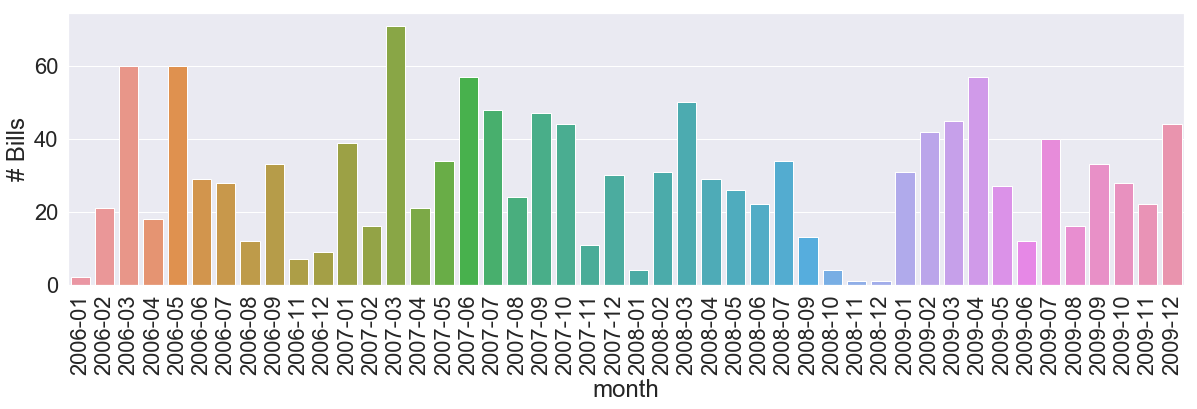

In [25]:
plt.figure(figsize=(20, 5))
d = pd.DataFrame(laws.groupby('month').size()).reset_index().rename(columns={0: 'count'})
sns.barplot(y='count', x='month', data=d);
plt.ylabel('# Bills');
plt.xticks(rotation=90);

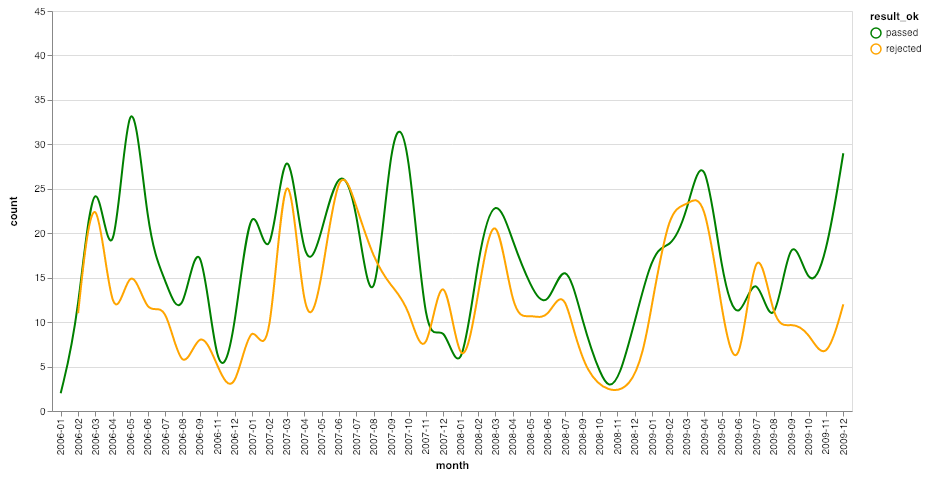

In [27]:
d = pd.DataFrame(laws.groupby(['month', 'result_ok']).size()).reset_index()
d = d.rename(columns={0: 'count'})

# Chart
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['month'], empty='none')
line = alt.Chart().mark_line(interpolate='basis').encode(
    x='month:O',
    y='count:Q',
    color=alt.Color('result_ok:N', 
                    scale=alt.Scale(domain=['passed', 'rejected'], 
                                    range=['green', 'orange'])))

alt.layer(line, data=d, width=800, height=400)

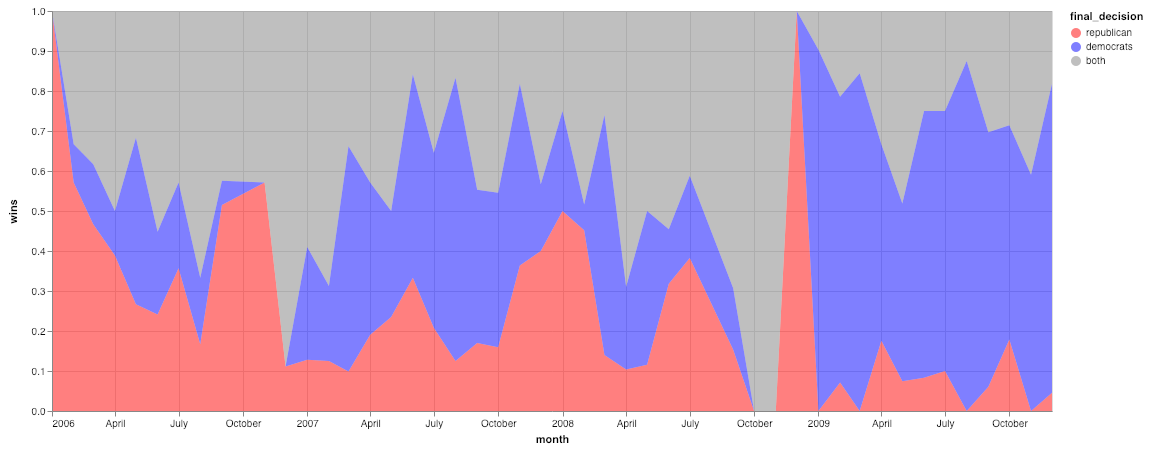

In [28]:
d = pd.DataFrame(laws.groupby(['month', 'final_decision']).size()).reset_index().rename(columns={0: 'wins'})
counts = pd.DataFrame(laws.groupby(['month']).size()).reset_index().rename(columns={0: 'total'})
d = d.merge(counts)
d['wins'] = d['wins'] / d['total']

alt.Chart(d, width=1000, height=400).mark_area(opacity=0.5).encode(
    x="month:T",
    y="wins:Q",
    color=alt.Color("final_decision:N", 
                    scale=alt.Scale(domain=['republican', 'democrats', 'both'], 
                              range=[pal['republican'], pal['democrats'], 'grey'])))

/Users/lia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


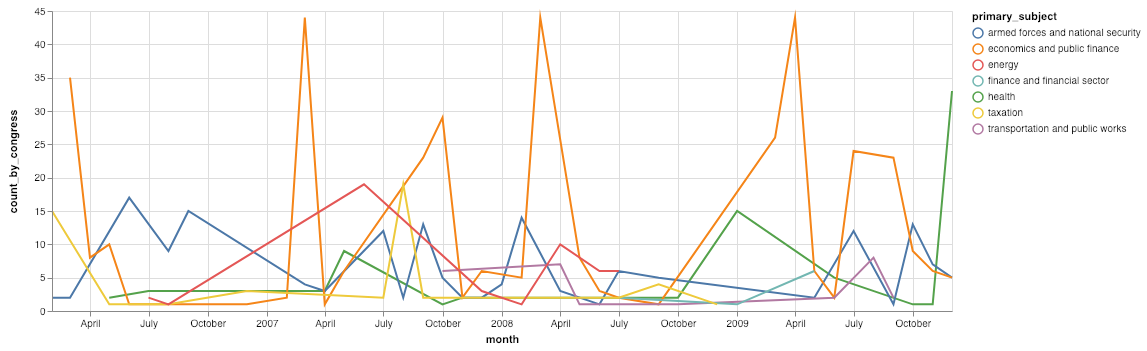

In [30]:
laws['primary_subject'] = laws['primary_subject'].str.lower()
count_by_subject = laws.groupby(['month', 'primary_subject']).size().reset_index().rename(columns={0: 'count_by_congress'})
total_count = all_laws.groupby('month').size().reset_index().rename(columns={0: 'count'})
d = count_by_subject.merge(total_count).sort_values(['month', 'count_by_congress'], ascending=False)
tops = ['economics and public finance', 
        'armed forces and national security', 
        'taxation', 'health', 'energy', 
        'transportation and public works', 
        'finance and financial sector', 'imigration']
d = d[d['primary_subject'].apply(lambda x: True if x in tops else False)]

alt.Chart(d, width=900, height=300).mark_line().encode(
    x='month:T',
    y='count_by_congress',
    color='primary_subject',
)

In [33]:
len(quarters)

46

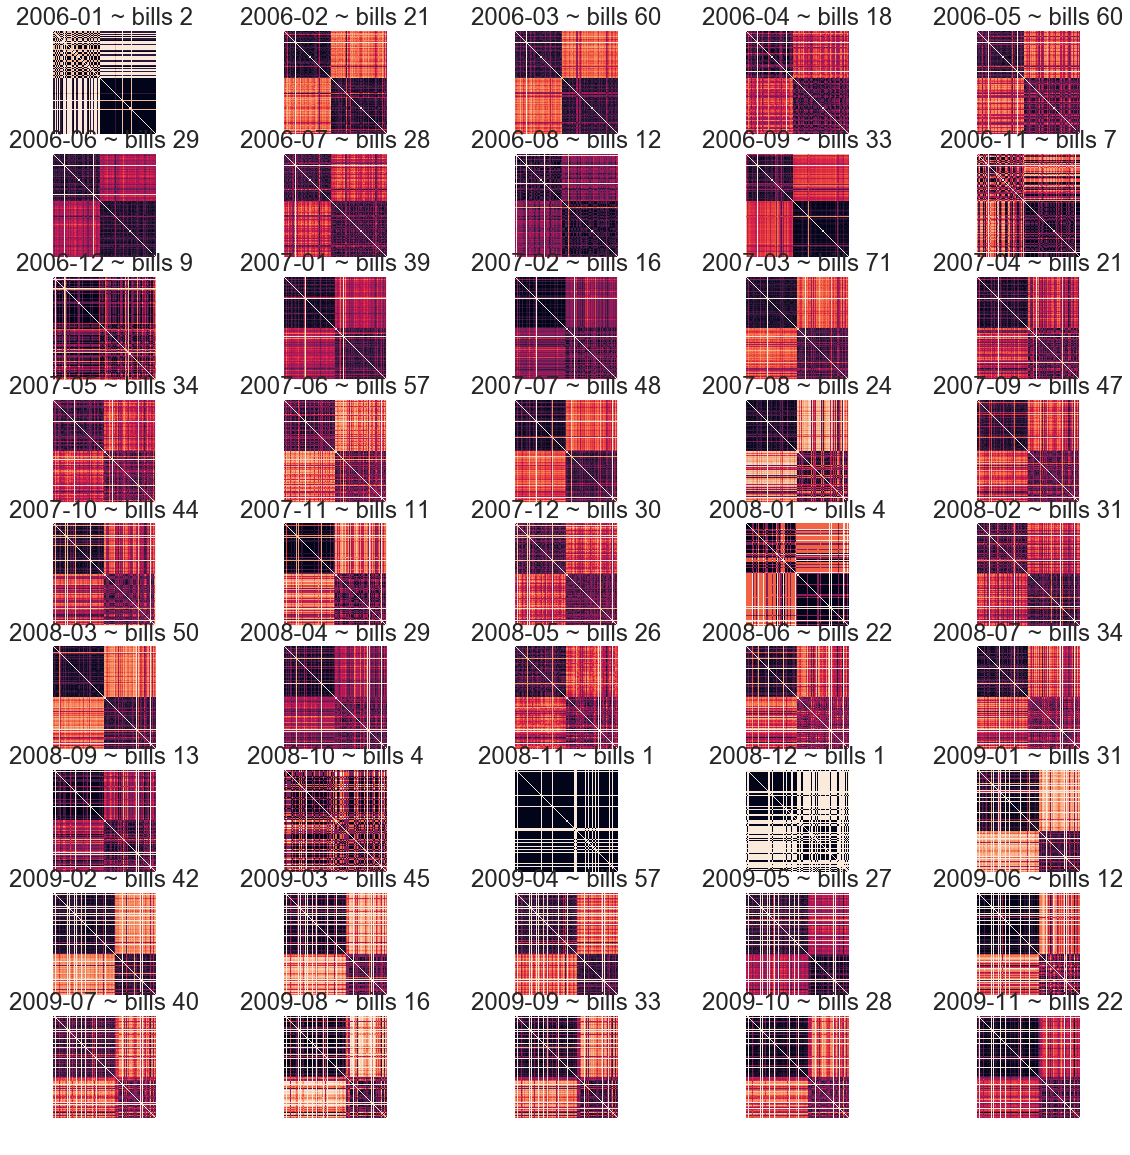

In [36]:
by = 'month'
quarters = sorted(laws[by].unique())

f, ax = plt.subplots(9, 5, figsize=(20, 20))
positions = np.array(range(45)).reshape(9, 5)
    
for j, q in enumerate(quarters[0:-1]):
    pos = np.where(positions==j)
    my_laws = list(laws[laws.month.apply(lambda x: x == q)]['law_id'])
    n = len(my_laws)
    if n > 0:
        sum_adjacencies = adjacencies[my_laws[0]]
        for l in my_laws[1:]:
            sum_adjacencies += adjacencies[l]
        
        sum_adjacencies /= n
        sum_adjacencies = 1 - sum_adjacencies # xunxo to get right color pattern
        
        ax[pos[0][0], pos[1][0]].imshow(sum_adjacencies)
    ax[pos[0][0], pos[1][0]].axis('off')
    ax[pos[0][0], pos[1][0]].set_title('{} ~ bills {}'.format(q, n))

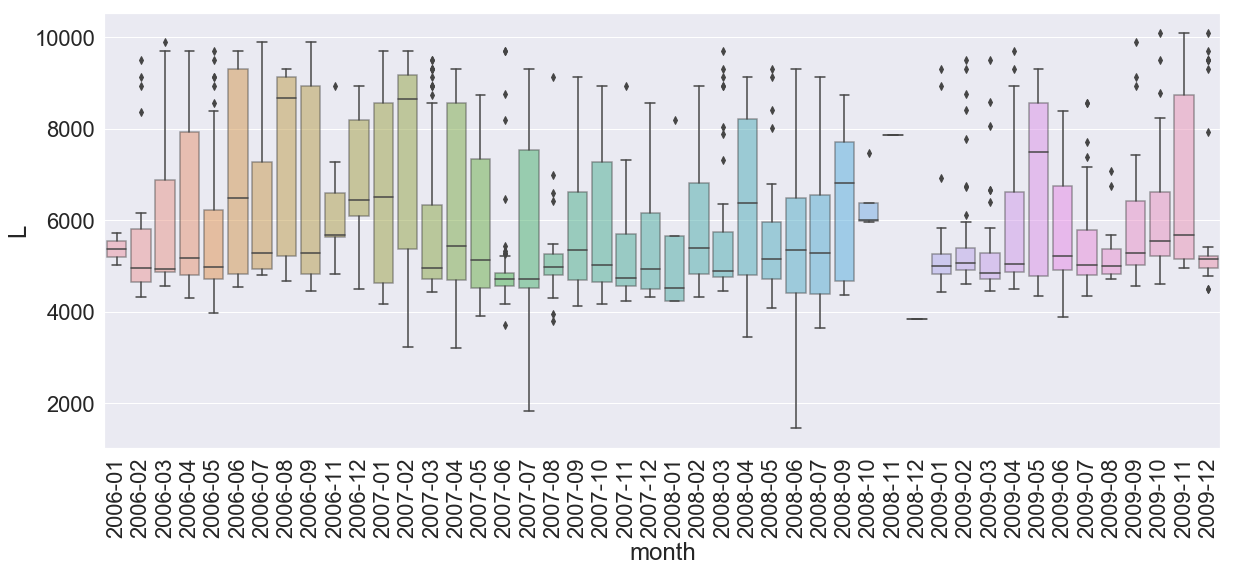

In [37]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='month', y='L', data=laws, boxprops=dict(alpha=.5))
plt.xticks(rotation=90);

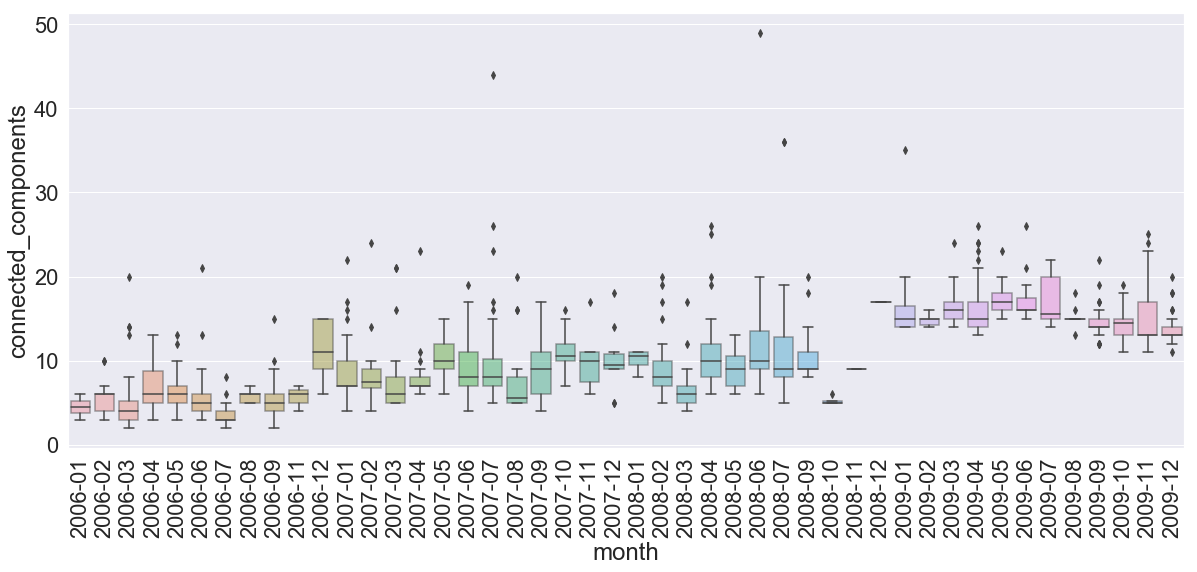

In [38]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='month', y='connected_components', data=laws, boxprops=dict(alpha=.5))
plt.xticks(rotation=90);